In [0]:
#pip install transformers -U

In [2]:
%pylab inline
import random
import numpy as np
from tqdm import tnrange
from time import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

from transformers import BertTokenizer, BertModel

Populating the interactive namespace from numpy and matplotlib


In [0]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [0]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [0]:
BATCH_SIZE = 16
DEC_SOS_IND = 0
DEC_EOS_IND = 1
DEC_UNK_IND = 2
MAX_SUMMARY_LEN = 502
MAX_DOC_LEN = 512
N_TRAIN = 44972
N_VAL = 5622
N_TEST = 5622
BERT_DIM = 768

## Load datasets

In [0]:
train = torch.load('data/train2.0.pt')
val = torch.load('data/val2.0.pt')
test = torch.load('data/test2.0.pt')

## BERT embeddings

In [0]:
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [0]:
bert_model = bert_model.cpu()
bert_model.eval();

In [0]:
def tokenized2batch(data, inds, bert_model, tokenizer):
    
    def BERTembeds2batch(embeds, sep_inds, first_pad_ind):
        if sep_inds.shape[0] == 0:
            return embeds[:first_pad_ind].unsqueeze(0), None
        batch = []
        tmpj = 0
        for j in range(sep_inds.shape[0] + 1):
            if j != sep_inds.shape[0]:
                if sep_inds[j] - tmpj != 0:
                    batch.append(embeds[tmpj:sep_inds[j]])
                tmpj = sep_inds[j] + 1
            else:
                batch.append(embeds[tmpj:first_pad_ind])
        lens = [s.shape[0] for s in batch]
        batch = pad_sequence(batch, batch_first=True, padding_value=0)
        pad_mask = torch.ones((batch.shape[0], batch.shape[1]), dtype=bool, device=batch.device)
        for i in range(pad_mask.shape[0]):
            pad_mask[i, :lens[i]] = False
        return batch, pad_mask
        
    pad_id = tokenizer.encode('[PAD]')[1]
    sep_id = tokenizer.encode('[SEP]')[1]
    
    batch = [0] * inds.shape[0]
    first_pad_inds = [0] * inds.shape[0]
    for i in range(inds.shape[0]):
        batch[i] = data[inds[i]]
        offset = 0
        while batch[i][-(offset + 1)] == sep_id:
            offset += 1
        if offset != 0:
            batch[i] = batch[i][:offset]
        first_pad_inds[i] = batch[i].shape[0]
    batch = pad_sequence(batch, batch_first=True, padding_value=pad_id)
    
    attn_mask = (batch != pad_id).to(torch.float)
    
    pos = torch.arange(0, batch.shape[1])
    pos_ids = torch.zeros_like(batch)
    sep_inds = [0] * batch.shape[0]
    for i in range(batch.shape[0]):
        tmp = pos[batch[i] == sep_id]
        sep_inds[i] = tmp
        tmpj = 0
        for j in range(tmp.shape[0] + 1):
            if j != tmp.shape[0]:
                pos_ids[i, tmpj:tmp[j] + 1] = pos[:tmp[j] + 1 - tmpj]
                tmpj = tmp[j] + 1
            else:
                pos_ids[i, tmpj:] = pos[:batch.shape[1] - tmpj]
                
    bert_embeds = None
    with torch.no_grad():
        model = bert_model.cuda()
        batch = batch.cuda()
        attn_mask = attn_mask.cuda()
        pos_ids = pos_ids.cuda()
        bert_embeds = model(batch, attention_mask=attn_mask, position_ids=pos_ids)[0]
        del model
        del batch
        del attn_mask
        del pos_ids
    
    batch = []
    for i in range(bert_embeds.shape[0]):
        batch.append(BERTembeds2batch(bert_embeds[i], sep_inds[i], first_pad_inds[i]))
    return batch

## Tokenizer for summaries

In [0]:
class summary_lang():
    def __init__(self):
        self.word2id = {'<SOS>': DEC_SOS_IND, '<EOS>' : DEC_EOS_IND, '<UNK>' : DEC_UNK_IND}
        self.id2word = {DEC_SOS_IND : '<SOS>', DEC_EOS_IND : '<EOS>', DEC_UNK_IND : '<UNK>'}
        self.word_counts = {}
        self.count = 3
        
    def __len__(self):
        return self.count
        
    def add_summaries(self, summaries, counter, thr=3):
        for summary in summaries:
            for word in summary:
                if counter[word] <= thr:
                    continue
                if word in self.word2id:
                    self.word_counts[word] += 1
                else:
                    self.word2id[word] = self.count
                    self.id2word[self.count] = word
                    self.count += 1
                    self.word_counts[word] = 1

## Load vocab

In [0]:
sum_lang = torch.load('data/vocab2.0.pt')

In [0]:
dec_vocab_size = len(sum_lang)

In [16]:
dec_vocab_size

49295

## Load tokenized summaries

In [0]:
train_sum = torch.load('data/train_sum2.0.pt')
val_sum = torch.load('data/val_sum2.0.pt')
test_sum = torch.load('data/test_sum2.0.pt')

## Training functions

In [0]:
def train_epoch(model, data, summaries, optimizer):
    model.train()
    full_losses = []
    nll_losses = []
    kl_losses = []
    inds = np.random.permutation(len(data))
    num_batches = int(np.ceil(len(data) / BATCH_SIZE))
    for i in tnrange(num_batches):

        batch = tokenized2batch(data, inds[i * BATCH_SIZE:(i + 1) * BATCH_SIZE], bert_model, bert_tokenizer)
        optimizer.zero_grad()
        full_batch, nll_batch, kl_batch = 0.0, 0.0, 0.0
        for j in range(len(batch)):
            docs, pad_mask = batch[j]
            summary = summaries[inds[i * BATCH_SIZE + j]].cuda()
            log_probs, mu, logsigma = model(docs, pad_mask, summary[:, :-1])
            full, nll, kl = model.full_vae_loss(log_probs, summary[:, 1:], mu, logsigma)
            if torch.isnan(full).item() or torch.isnan(nll).item() or torch.isnan(kl).item():
                print(mu)
                print(logsigma)
                print(full)
                print(nll)
                print(kl)
                raise ValueError
            full_batch = full_batch + (full / len(batch))
            nll_batch = nll_batch + (nll / len(batch))
            kl_batch = kl_batch + (kl / len(batch))       
        full_batch.backward()
        optimizer.step()
        
        full_losses.append(full_batch.item())
        nll_losses.append(nll_batch.item())
        kl_losses.append(kl_batch.item())
   
    return full_losses, nll_losses, kl_losses

def val_vae(model, data, summaries):
    model.eval()
    full_losses = []
    nll_losses = []
    kl_losses = []
    inds = np.arange(len(data))
    num_batches = int(np.ceil(len(data) / BATCH_SIZE))
    with torch.no_grad():
        for i in tnrange(num_batches):

            batch = tokenized2batch(data, inds[i * BATCH_SIZE:(i + 1) * BATCH_SIZE], bert_model, bert_tokenizer)

            full_batch, nll_batch, kl_batch = 0.0, 0.0, 0.0
            for j in range(len(batch)):
                docs, pad_mask = batch[j]
                summary = summaries[inds[i * BATCH_SIZE + j]].cuda()
                log_probs, mu, logsigma = model(docs, pad_mask, summary[:, :-1], deterministic=True)
                full, nll, kl = model.full_vae_loss(log_probs, summary[:, 1:], mu, logsigma)
                full_batch = full_batch + (full / len(batch))
                nll_batch = nll_batch + (nll / len(batch))
                kl_batch = kl_batch + (kl / len(batch))

            del batch

            full_losses.append(full_batch.item())
            nll_losses.append(nll_batch.item())
            kl_losses.append(kl_batch.item())
     
    return full_losses, nll_losses, kl_losses

def plot_history(train_history, val_history):
    plt.figure(figsize=(14, 4))
    plt.subplot(131)
    plt.title('Full loss (nll + kl)')
    plt.plot(train_history[0], label='train', zorder=1)
    
    points = np.array(val_history[0])
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()
    
    
    plt.subplot(132)
    plt.title('Nll loss')
    plt.plot(train_history[1], label='train', zorder=1)
    
    points = np.array(val_history[1])
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()
    
    plt.subplot(133)
    plt.title('Kl divergence')
    plt.plot(train_history[2], label='train', zorder=1)
    
    points = np.array(val_history[2])
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.tight_layout()
    plt.show()

def train_vae(model, opt, train, train_sum, val, val_sum, num_epochs, init_epoch=0, train_log=([], [], []), val_log=([], [], [])):
    train_full_log, train_nll_log, train_kl_log = train_log
    val_full_log, val_nll_log, val_kl_log = val_log
    
    t1 = time()
    
    for epoch in range(init_epoch, init_epoch + num_epochs):
        tic = time()
        full_losses, nll_losses, kl_losses = train_epoch(model, train, train_sum, opt)
        tac = time()

        tic1 = time()
        val_full_losses, val_nll_losses, val_kl_losses = val_vae(model, val, val_sum)
        tac1 = time()

        train_full_log.extend(full_losses)
        train_nll_log.extend(nll_losses)
        train_kl_log.extend(kl_losses)

        val_full_log.append((np.ceil(len(train) / BATCH_SIZE) * (epoch + 1), np.mean(val_full_losses)))
        val_nll_log.append((np.ceil(len(train) / BATCH_SIZE) * (epoch + 1), np.mean(val_nll_losses)))
        val_kl_log.append((np.ceil(len(train) / BATCH_SIZE) * (epoch + 1), np.mean(val_kl_losses)))
        
        checkpoint_state = {'epoch': epoch,
                            'state_dict': model.state_dict(),
                            'optimizer': opt.state_dict()}
        torch.save(checkpoint_state, 'vae_attn/checkpoints/epoch{}.pt'.format(epoch))

        losses_log = {'train' : (train_full_log, train_nll_log, train_kl_log),
                      'val' : (val_full_log, val_nll_log, val_kl_log)}
        torch.save(losses_log, 'vae_attn/losses_log.pt')
            
        clear_output()
        plot_history((train_full_log, train_nll_log, train_kl_log), (val_full_log, val_nll_log, val_kl_log))
        t2 = time()
        print('EPOCH {}:'.format(epoch))
        print('Total time from start: {}min {}s'.format((t2 - t1) // 60, (t2 - t1) % 60))
        print('----------------------------------')
        print('TRAIN: {}min {}s for epoch\nMean full loss = {}\nMean nll loss = {}\nMean kl loss = {}'.format((tac - tic) // 60,
                                                                                                              (tac - tic) % 60,
                                                                                                              np.mean(full_losses),
                                                                                                              np.mean(nll_losses),
                                                                                                              np.mean(kl_losses)))
        print('----------------------------------')
        print('VAL: {}min {}s for epoch\nMean full loss = {}\nMean nll loss = {}\nMean kl loss = {}'.format((tac1 - tic1) // 60,
                                                                                                            (tac1 - tic1) % 60,
                                                                                                            val_full_log[-1][1],
                                                                                                            val_nll_log[-1][1],
                                                                                                            val_kl_log[-1][1]))
    
    return losses_log

## Model

In [0]:
# from https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.0, max_len=512):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [0]:
# there are some things from https://pytorch.org/docs/stable/_modules/torch/nn/modules/transformer.html
class TrDecoder(nn.Module):
    def __init__(self, dec_embed_dim, dec_depth, dec_n_heads, dec_feedforward_dim):
        super(TrDecoder, self).__init__()
        
        self.dec_embed_dim = dec_embed_dim
        self.dec_depth = dec_depth
        self.dec_n_heads = dec_n_heads
        self.dec_feedforward_dim = dec_feedforward_dim
        
        self.transformer_layers = nn.ModuleList([nn.TransformerDecoderLayer(dec_embed_dim,
                                                                            dec_n_heads,
                                                                            dim_feedforward=dec_feedforward_dim,
                                                                            activation='gelu') for i in range(dec_depth)])
        
    def forward(self, embs, mem, seq_mask, pad_mask=None):
        embs = embs.transpose(0, 1)

        for i in range(self.dec_depth):
            embs = self.transformer_layers[i](embs, mem, tgt_mask=seq_mask, memory_key_padding_mask=pad_mask)
            
        return embs.transpose(0, 1)
    
    def generate_square_subsequent_mask(self, sz):
        r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


class MDVAE(nn.Module):
    def __init__(self, input_size, enc_depth, enc_n_heads, enc_feedforward_dim,
                 dec_num_embeds, dec_embed_dim, dec_depth, dec_n_heads, dec_feedforward_dim,
                 distr_dim, dict_constants, mode='VAE'):
        super(MDVAE, self).__init__()
        
        # hyperparameters:
        self.input_size = input_size
        self.enc_depth = enc_depth
        self.enc_n_heads = enc_n_heads
        self.enc_feedforward_dim = enc_feedforward_dim
        self.dec_num_embeds = dec_num_embeds
        self.dec_embed_dim = dec_embed_dim
        self.dec_depth = dec_depth
        self.dec_n_heads = dec_n_heads
        self.dec_feedforward_dim = dec_feedforward_dim
        self.distr_dim = distr_dim
        self.mode = mode
        self.DEC_SOS_IND = dict_constants['DEC_SOS_IND']
        self.DEC_EOS_IND = dict_constants['DEC_EOS_IND']
        self.MAX_SUMMARY_LEN = dict_constants['MAX_SUMMARY_LEN']
        self.MAX_DOC_LEN = dict_constants['MAX_DOC_LEN']
        
        # encoder layers:
        self.enc_pos_emb = PositionalEncoding(input_size, 0.0, self.MAX_DOC_LEN)
        self.mu_linear = nn.Linear(input_size, distr_dim)
        self.logsigma_linear = None
        if mode == 'VAE':
            self.logsigma_linear = nn.Linear(input_size, distr_dim)
        elif mode != 'AE':
            raise ValueError('Unknown mode: must be "VAE" or "AE", not {}'.format(mode))
        enc_layer = nn.TransformerEncoderLayer(d_model=input_size,
                                               nhead=enc_n_heads,
                                               dim_feedforward=enc_feedforward_dim,
                                               activation="gelu")
        self.document_encoder = nn.TransformerEncoder(enc_layer, num_layers=enc_depth)
        self.doc_encoder_linear = nn.Linear(input_size * 2, 1, bias=False)
        
        # decoder layers:
        self.decoder_emb = nn.Embedding(dec_num_embeds, dec_embed_dim)
        self.dec_pos_emb = PositionalEncoding(dec_embed_dim, 0.0, self.MAX_SUMMARY_LEN)
        self.dec_enc_to_mem = nn.Linear(input_size, dec_embed_dim)
        self.dec_latent_to_add_mem = nn.Linear(distr_dim, dec_embed_dim)
        self.decoder = TrDecoder(self.dec_embed_dim, self.dec_depth, self.dec_n_heads, self.dec_feedforward_dim)
        seq_mask = self.decoder.generate_square_subsequent_mask(self.MAX_SUMMARY_LEN)
        self.register_buffer('seq_mask', seq_mask)
        self.decoder_linear1 = nn.Linear(dec_embed_dim, dec_embed_dim)
        self.decoder_linear2 = nn.Linear(dec_embed_dim, dec_num_embeds)
    
    def encode_vae(self, inputs, pad_mask=None):
        # inputs: (n_docs, n_tokens, input_size)

        # BERT embeddings per document + positional embeddings to document embeddings:
        x = self.enc_pos_emb(inputs).transpose(0, 1)
        x = self.document_encoder(x, src_key_padding_mask=pad_mask).transpose(0, 1)
        if pad_mask is None:
            doc_embeds = torch.mean(x, dim=1)
        else:
            not_pad_mask = torch.logical_not(pad_mask)
            doc_embeds = torch.sum(x * not_pad_mask.unsqueeze(2), dim=1) / torch.sum(not_pad_mask, dim=1).view(-1, 1)

        # document embeddings to set-of-documents embedding:
        if doc_embeds.shape[0] == 1:       # only 1 document in inputs
            set_of_docs_emb = doc_embeds
        else:                              # more than 1 document in inputs
            d_sum = torch.sum(doc_embeds, dim=0)
            d_conc = torch.cat((doc_embeds, d_sum.view(1, -1).expand(doc_embeds.shape[0], -1)), -1)
            weights = self.doc_encoder_linear(d_conc)
            weights = F.softmax(weights, dim=0)
            set_of_docs_emb = torch.mm(weights.view(1, -1), doc_embeds)
            
        # set-of-documents embedding to mu and logvar:
        mu = self.mu_linear(set_of_docs_emb)
        logsigma = self.logsigma_linear(set_of_docs_emb)
        if pad_mask is None:
            return mu, logsigma, (x.reshape((-1, x.shape[2])).unsqueeze(1), None)
        else:
            return mu, logsigma, (x.reshape((-1, x.shape[2])).unsqueeze(1), pad_mask.reshape((1, -1)))
    
    def encode_ae(self, inputs, pad_mask=None):
        # inputs: (n_docs, n_tokens, input_size)
        
        # BERT embeddings per document + positional embeddings to document embeddings:
        x = self.enc_pos_emb(inputs).transpose(0, 1)
        x = self.document_encoder(x, src_key_padding_mask=pad_mask).transpose(0, 1)
        if pad_mask is None:
            doc_embeds = torch.mean(x, dim=1)
        else:
            not_pad_mask = torch.logical_not(pad_mask)
            doc_embeds = torch.sum(x * not_pad_mask.unsqueeze(2), dim=1) / torch.sum(not_pad_mask, dim=1).view(-1, 1)
        
        # document embeddings to set-of-documents embedding:
        if doc_embeds.shape[0] == 1:       # only 1 document in inputs
            set_of_docs_emb = doc_embeds
        else:                              # more than 1 document in inputs
            d_sum = torch.sum(doc_embeds, dim=0)
            d_conc = torch.cat((doc_embeds, d_sum.view(1, -1).expand(doc_embeds.shape[0], -1)), -1)
            weights = self.doc_encoder_linear(d_conc)
            weights = F.softmax(weights, dim=0)
            set_of_docs_emb = torch.mm(weights.view(1, -1), doc_embeds)
        
        # set-of-documents embedding to mu:
        mu = self.mu_linear(set_of_docs_emb)
        if pad_mask is None:
            return mu, (x.reshape((-1, x.shape[2])).unsqueeze(1), None)
        else:
            return mu, (x.reshape((-1, x.shape[2])).unsqueeze(1), pad_mask.reshape((1, -1)))
    
    def reparam_sample(self, mu, logsigma):
        std = torch.exp(0.5 * logsigma)
        eps = torch.randn_like(std)
        return eps * std + mu
    
    def decode(self, z, memory, pad_mask=None, target_summary=None, max_summary_len=None):
        # teacher forcing:
        if target_summary is not None:
            if target_summary.shape[1] > self.MAX_SUMMARY_LEN:
                raise ValueError("target_summary's len must be <= MAX_SUMMARY_LEN = {}".format(self.MAX_SUMMARY_LEN))
            embs = self.decoder_emb(target_summary)
            embs = self.dec_pos_emb(embs)
            mem = self.dec_enc_to_mem(memory)
            add_mem = self.dec_latent_to_add_mem(z.view(1, 1, -1))
            embs = embs + add_mem
            decoded = self.decoder(embs, mem=mem, seq_mask=self.seq_mask[:embs.shape[1], :embs.shape[1]], pad_mask=pad_mask)
            return F.log_softmax(self.decoder_linear2(F.relu(self.decoder_linear1(decoded))), dim=-1)
        # autoregressive one-by-one:
        else:
            if max_summary_len is None:
                max_len = self.MAX_SUMMARY_LEN
            else:
                max_len = min(max_summary_len, self.MAX_SUMMARY_LEN)
            inds = [self.DEC_SOS_IND]
            embs = self.decoder_emb(torch.tensor([inds], dtype=torch.long, device=z.device))
            embs = self.dec_pos_emb(embs)
            mem = self.dec_enc_to_mem(memory)
            add_mem = self.dec_latent_to_add_mem(z.view(1, 1, -1))
            embs = embs + add_mem
            log_probs = None
            for i in range(max_len - 2):
                decoded = self.decoder(embs, mem=mem, seq_mask=self.seq_mask[:embs.shape[1], :embs.shape[1]], pad_mask=pad_mask)
                log_probs = F.log_softmax(self.decoder_linear2(F.relu(self.decoder_linear1(decoded))), dim=-1)
                next_ind = torch.argmax(log_probs, dim=-1).view(-1)[-1].item()
                #next_ind = torch.multinomial(torch.exp(log_probs[0, -1].view(-1)), 1).item()
                if next_ind == self.DEC_EOS_IND:
                    return log_probs
                inds.append(next_ind)
                embs = self.decoder_emb(torch.tensor([inds], dtype=torch.long, device=z.device))
                embs = self.dec_pos_emb(embs)
                embs = embs + add_mem
            return log_probs
            
    def forward(self, inputs, pad_mask=None, summary=None, max_summary_len=None, deterministic=False):
        # inputs: (n_docs, n_sentences, input_size)
        
        if self.mode == 'VAE':
            if not deterministic:
                mu, logsigma, (mem, mem_pad) = self.encode_vae(inputs, pad_mask)
                z = self.reparam_sample(mu, logsigma)
                return [self.decode(z, mem, mem_pad, summary, max_summary_len), mu, logsigma]
            else:
                mu, logsigma, (mem, mem_pad) = self.encode_vae(inputs, pad_mask)
                return [self.decode(mu, mem, mem_pad, summary, max_summary_len), mu, logsigma]
        else:
            z, (mem, mem_pad) = self.encode_ae(inputs, pad_mask)
            return self.decode(z, mem, mem_pad, summary, max_summary_len), z
    
    # generate text summary
    def summarize(self, inp, dec_vocab_ind2word, pad_mask=None, deterministic=True, max_summary_len=None):  
        # deterministic: latent vector z equals mu if True, else z is sampled
        
        with torch.no_grad():
            m = self.training
            self.eval()
            if deterministic or self.mode == 'AE':
                z, (mem, mem_pad) = self.encode_ae(inp, pad_mask)
            else:
                mu, logsigma, (mem, mem_pad) = self.encode_vae(inp, pad_mask)
                z = self.reparam_sample(mu, logsigma)
            summary_inds = torch.reshape(torch.argmax(self.decode(z, mem, mem_pad, None, max_summary_len), dim=-1), (-1,))
            summary = ''
            for ind in summary_inds:
                summary += dec_vocab_ind2word[ind.item()] + ' '
            self.train(m)
            return summary[:-1]
    
    def full_vae_loss(self, pred, target, mu, logsigma, reduction='mean'):
        nll = F.nll_loss(pred.squeeze(0), target.view(-1), reduction=reduction)
        kl = -0.5 * torch.sum(1 + logsigma - mu**2 - logsigma.exp())
        if reduction == 'mean':
            kl_weight = 1 / target.view(-1).shape[0]
        else:
            kl_weight = 1
        full = nll + kl_weight * kl
        #full = nll + kl
        return full, nll, kl

## Training

In [0]:
dict_constants = {}
dict_constants['DEC_SOS_IND'] = DEC_SOS_IND
dict_constants['DEC_EOS_IND'] = DEC_EOS_IND
dict_constants['MAX_SUMMARY_LEN'] = MAX_SUMMARY_LEN
dict_constants['MAX_DOC_LEN'] = MAX_DOC_LEN

In [0]:
model = MDVAE(input_size=BERT_DIM,
              enc_depth=4,
              enc_n_heads=8,
              enc_feedforward_dim=2048,
              dec_num_embeds=dec_vocab_size,
              dec_embed_dim=256,
              dec_depth=4,
              dec_n_heads=8,
              dec_feedforward_dim=1024,
              distr_dim=256,
              dict_constants=dict_constants,
              mode='VAE')

In [23]:
np.sum([p.numel() for p in model.parameters()])

52281743

In [24]:
np.sum([p.numel() for p in model.parameters() if p.requires_grad])

52281743

In [0]:
#checkpoint = torch.load('vae_attn/checkpoints/epoch{}.pt'.format(14))
#losses_log = torch.load('vae_attn/losses_log.pt')

In [0]:
#model.load_state_dict(checkpoint['state_dict'])
model = model.cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.0001)
#opt.load_state_dict(checkpoint['optimizer'])
#for g in opt.param_groups:
#    g['lr'] = 0.0008

In [0]:
init_ep = checkpoint['epoch'] + 1

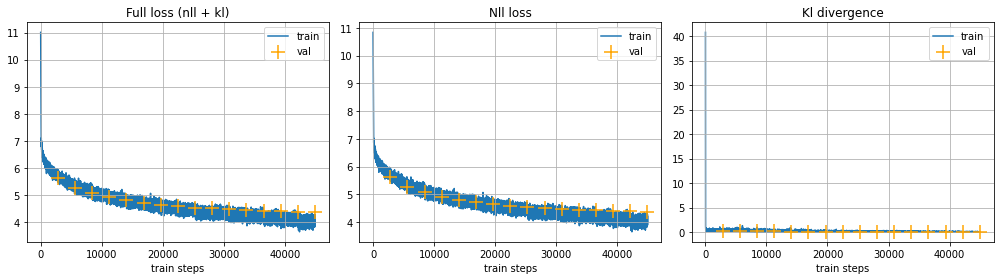

EPOCH 15:
Total time from start: 44.0min 44.565733671188354s
----------------------------------
TRAIN: 41.0min 47.217060804367065s for epoch
Mean full loss = 4.037225985688189
Mean nll loss = 4.0370403190220605
Mean kl loss = 0.04298572242790081
----------------------------------
VAL: 2.0min 54.444171667099s for epoch
Mean full loss = 4.375735735351389
Mean nll loss = 4.375541426918724
Mean kl loss = 0.044588663668202404


In [0]:
#losses_log = train_vae(model, opt, train, train_sum, val, val_sum, 3, init_epoch=init_ep, train_log=losses_log['train'], val_log=losses_log['val'])
losses_log = train_vae(model, opt, train, train_sum, val, val_sum, 10, init_epoch=0, train_log=([], [], []), val_log=([], [], []))

In [0]:
#model.eval()
#model.summarize(torch.randn((3, 150, 768)).cuda() + 10, sum_lang.id2word, max_summary_len=20)